# Ames Housing Price Prediction Analysis

## Overview

This notebook aims to analyze the Ames Housing dataset and build predictive models for housing prices. The notebook is organized into several sections, each focusing on a different aspect of the data analysis and modeling process. The primary goal is to provide a comprehensive understanding of the factors influencing house prices and to develop robust predictive models.

### Exploratory Data Analysis
-   **Get to know the data & Basic Statistics**

### Data Preparation
Data preparation involves handling missing values, encoding categorical variables, and selecting relevant features for modeling.

1. **Handling Missing Values**: Missing data is imputed using appropriate strategies to ensure completeness of the dataset.
2. **Encoding Categorical Variables**: Categorical variables are encoded using one-hot encoding to make them suitable for modeling.
3. **Feature Selection**: Relevant features are selected based on their importance and correlation with the target variable, SalePrice.

### Univariate Analysis
Univariate analysis focuses on the distribution and characteristics of individual variables.

1. **Histograms**: Histograms are used to visualize the distribution of numerical features.
2. **Box Plots**: Box plots are used to identify outliers and understand the spread of numerical features.

### Bivariate Analysis
Bivariate analysis explores the relationships between pairs of variables.

1. **Correlation Heatmap**: A heatmap of the correlation matrix is used to identify strong relationships between features and the target variable.
2. **Scatter Plots**: Scatter plots are used to visualize the relationships between selected features and SalePrice.

### Multivariate Analysis
Multivariate analysis examines the relationships between multiple variables simultaneously to identify patterns and interactions that may not be evident in univariate or bivariate analyses.

### Baseline Linear Regression Models
Baseline linear regression models are built to understand the linear relationships between selected features and SalePrice.

### Advanced Regression Analysis
Advanced regression techniques are employed to improve the predictive performance of the models.

1. **Ridge Regression**: A regularized regression technique to handle multicollinearity and prevent overfitting.
2. **Lasso Regression**: Another regularized regression technique that performs feature selection by shrinking some coefficients to zero.
3. **ElasticNet Regression**: A combination of Ridge and Lasso regression that balances their strengths.

### Model Training and Validation
Various machine learning models are trained and validated to predict housing prices.

1. **Support Vector Regression (SVR)**: A robust regression technique that aims to minimize prediction errors.
2. **Artificial Neural Networks (ANN)**: A deep learning approach that captures complex patterns in the data.
3. **XGBoost**: An ensemble learning method that builds multiple weak learners to create a strong predictive model.

### Ensemble Modeling
Ensemble modeling combines multiple models to improve overall prediction accuracy.

1. **Stacking Models**: Different models are stacked to leverage their individual strengths.
2. **Blending Models**: Predictions from multiple models are blended to achieve better performance.

### Prediction
The final models are used to make predictions on the test data, and the results are evaluated to determine the best-performing model.

## Goals
- **Identify Key Features**: Determine the most important features influencing housing prices.
- **Build Robust Models**: Develop and validate different regression models to accurately predict housing prices.
- **Improve Predictive Accuracy**: Use advanced techniques and ensemble methods to enhance the performance of the predictive models.

This analysis will provide insights into the factors affecting housing prices in Ames and demonstrate the application of various machine learning techniques to build effective predictive models.


In [ ]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import keras
import time
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from keras import layers
from keras import models


In [ ]:
# Load the Ames dataset
file_path = '../data/AmesData.csv'
ames_df = pd.read_csv(file_path)

# Specifically replace blanks in 'MasVnrArea' with 0
ames_df.replace({'MasVnrArea': 'nan'}, 0, inplace=True)

# Identify columns with missing values
missing_values = ames_df.isnull().sum()
missing_cols = missing_values[missing_values > 0].index.tolist()

# Separate numerical and categorical columns with missing values
num_cols_with_missing = ames_df.select_dtypes(include=[np.number]).columns[ames_df.select_dtypes(include=[np.number]).isnull().any()].tolist()
cat_cols_with_missing = ames_df.select_dtypes(exclude=[np.number]).columns[ames_df.select_dtypes(exclude=[np.number]).isnull().any()].tolist()

# Handle missing values for numerical columns
num_imputer = SimpleImputer(strategy='median')
ames_df[num_cols_with_missing] = num_imputer.fit_transform(ames_df[num_cols_with_missing])

# Handle missing values for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
ames_df[cat_cols_with_missing] = cat_imputer.fit_transform(ames_df[cat_cols_with_missing])

# Ensure no missing values remain
print("\nColumns with missing values after imputation and their counts:")
print(ames_df.isnull().sum()[ames_df.isnull().sum() > 0])

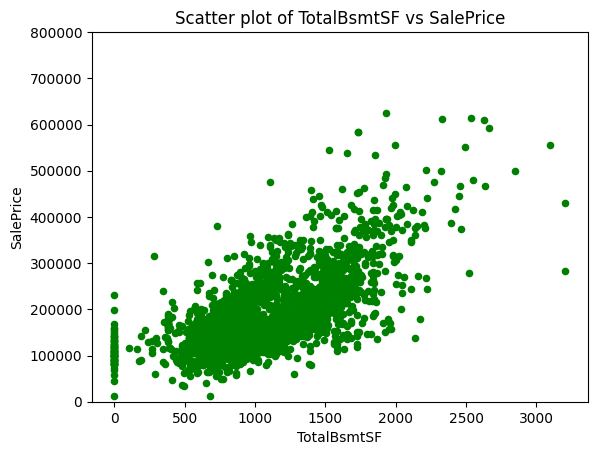

In [3]:
# Standardize 'SalePrice'
saleprice_scaled = StandardScaler().fit_transform(ames_df['SalePrice'].values.reshape(-1, 1))
plt.show()

# Remove outliers based on 'GrLivArea'
ames_df.sort_values(by='GrLivArea', ascending=False)[:2]
ames_df = ames_df.drop(ames_df[ames_df['GrLivArea'] > 4000].index)

# Plot scatter plot for 'TotalBsmtSF' vs 'SalePrice'
var = 'TotalBsmtSF'
data = pd.concat([ames_df['SalePrice'], ames_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', color = 'green', ylim=(0, 800000))
plt.title('Scatter plot of TotalBsmtSF vs SalePrice')
plt.show()

In [4]:
# Display the first few rows of the Ames dataset
print("First few rows of the Ames dataset:")
print(ames_df.head())

# Display summary statistics of the Ames dataset
print("\nSummary statistics of the Ames dataset:")
print(ames_df.describe())

# List the column names of the Ames dataset
print("\nColumn names of the Ames dataset:")
print(ames_df.columns.tolist())

# Split the data into training and testing sets
train_df, test_df = train_test_split(ames_df, test_size=0.2, random_state=42)

# Display the first few rows of the training set
print("\nFirst few rows of the training set:")
print(train_df.head())

# Display the first few rows of the testing set
print("\nFirst few rows of the testing set:")
print(test_df.head())

First few rows of the Ames dataset:
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          20       RL           78    10140   Pave  Grvl      Reg   
1          20       RL           88    12803   Pave  Grvl      IR1   
2          60       RL           86    11839   Pave  Grvl      Reg   
3          90       RL           75     8235   Pave  Grvl      Reg   
4          20       RL           60     9060   Pave  Grvl      Reg   

  LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...      648     Fa  GdPrv        Shed   
1         Lvl    AllPub    Inside  ...        0     Ex  MnPrv        Shed   
2         Lvl    AllPub    Inside  ...        0     Ex  MnPrv        Shed   
3         Lvl    AllPub    Inside  ...        0     Ex  MnPrv        Shed   
4         Lvl    AllPub    Inside  ...        0     Ex  MnPrv        Shed   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      1 

In [5]:
train_df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2211.000000,2211.000000,2211.000000,2211.000000,2211.00000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,...,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.000000,2211.00000,2211.000000,2211.000000
mean,56.180461,57.832203,10277.734962,6.184080,5.57033,1972.789688,1984.802352,104.818634,451.950249,53.603799,...,96.873360,48.305744,22.127092,2.482587,17.637268,2.208051,45.781999,6.25735,2007.789688,185201.412483
std,40.981284,33.454181,8379.516457,1.365721,1.06440,29.457809,20.562746,178.869930,441.751781,176.533133,...,128.063934,65.945732,64.150640,24.286004,59.229514,36.188110,462.162916,2.69645,1.321114,78282.866386
min,20.000000,0.000000,1300.000000,1.000000,1.00000,1880.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,2006.000000,12789.000000
25%,20.000000,43.000000,7586.500000,5.000000,5.00000,1955.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.00000,2007.000000,132000.000000
50%,50.000000,63.000000,9550.000000,6.000000,5.00000,1975.000000,1993.000000,0.000000,381.000000,0.000000,...,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.00000,2008.000000,167000.000000
75%,70.000000,79.000000,11645.000000,7.000000,6.00000,2002.000000,2004.000000,171.000000,755.500000,0.000000,...,169.500000,72.500000,0.000000,0.000000,0.000000,0.000000,0.000000,8.00000,2009.000000,217150.000000
max,190.000000,313.000000,215245.000000,10.000000,9.00000,2010.000000,2010.000000,1600.000000,2288.000000,1526.000000,...,1424.000000,570.000000,1012.000000,508.000000,576.000000,800.000000,15500.000000,12.00000,2010.000000,625000.000000


In [6]:
# Get the number of rows and columns in the Ames dataset
num_rows, num_columns = ames_df.shape

print(f"The dataset contains {num_rows} rows and {num_columns} columns.")

The dataset contains 2764 rows and 80 columns.


In [7]:
# Print the column names of the Ames dataset
print("Column names of the Ames dataset:")
print(ames_df.columns.tolist())

Column names of the Ames dataset:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'Screen

In [8]:
# Print the column names of the Ames dataset in groups of 5
columns = ames_df.columns.tolist()
print("Column names of the Ames dataset:")

for i in range(0, len(columns), 10):
    print(columns[i:i+10])

Column names of the Ames dataset:
['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig']
['LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']
['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual']
['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC']
['CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
['BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish']
['GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', '

#### 2. Basic Statistical Analysis

In [9]:
# Histograms for key features
train_df.hist(figsize=(20, 20), color = 'blue')  # create histograms for all numerical features in the dataset
plt.show()                       # display the plots

KeyboardInterrupt: 

In [ ]:
# Bar plot of overall quality
plt.figure(figsize=(10, 6))  # set the figure size
sns.countplot(x='OverallQual', data=train_df, color = 'blue')  # create a count plot for the OverallQual column
plt.title('Overall Quality Distribution')  # add a title to the plot
plt.show()  # display the plot

In [ ]:
# Distribution of sale prices
plt.figure(figsize=(10, 6))  # set the figure size
sns.histplot(train_df['SalePrice'], bins=50, kde=True, color ='darkorange')  # create a histogram with a kernel density estimate for the SalePrice column
plt.title('Distribution of Sale Prices')  # add a title to the plot
plt.show()  # display the plot

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Scatter plot of square footage vs. house price
plt.figure(figsize=(6, 4))  # Set the figure size
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df, color = 'blue')  # Create a scatter plot for square footage (GrLivArea) vs. house price (SalePrice)
plt.title('Square Footage vs. SalePrice')  # Add a title to the plot
plt.show()  # Display the plot

# Scatter plot of age of home vs. house price
plt.figure(figsize=(6, 4))  # Set the figure size
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_df, color = 'blue')  # Create a scatter plot for the age of home (YearBuilt) vs. house price (SalePrice)
plt.title('Age of Home vs. SalePrice')  # Add a title to the plot
plt.show()  # Display the plot

# Boxplot of neighborhood vs. house price
plt.figure(figsize=(6, 4))  # Set the figure size
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_df, hue='Neighborhood', palette = 'Blues')  # Create a box plot for neighborhood (Neighborhood) vs. house price (SalePrice)
plt.title('Neighborhood vs. SalePrice')  # Add a title to the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better readability
plt.show()  # Display the plot

# Boxplot of neighborhood vs. house price
plt.figure(figsize=(6, 4))  # Set the figure size
sns.boxplot(x='OverallQual', y='SalePrice', data=train_df, hue='OverallQual', palette = 'Blues')  # Create a box plot 
plt.title('Overall Quality vs SalePrice')  # Add a title to the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better readability
plt.show()  # Display the plot

# Boxplot of year built vs. sale price
plt.figure(figsize=(18, 4))  # Set the figure size
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_df, hue='YearBuilt', palette = 'Blues')  # Create a box plot for year built (YearBuilt) vs. house price (SalePrice)
plt.title('YearBuilt vs. SalePrice')  # Add a title to the plot
plt.xticks(rotation=90)  # Rotate the x-axis labels by 90 degrees for better readability
plt.show()  # Display the plot

In [ ]:
#scatterplot
sns.set_theme(style="ticks")
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], height = 2.5, hue = 'SalePrice')
plt.show()

In [ ]:
# Select only categorical columns
categorical_cols = train_df.select_dtypes(exclude=[np.number]).columns.tolist()

# Determine the number of rows and columns for the subplot grid
n_cols = 6
n_rows = len(categorical_cols) // n_cols + (len(categorical_cols) % n_cols > 0)

# Plot count plots for categorical features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, feature in enumerate(categorical_cols):
    sns.countplot(x=train_df[feature], ax=axes[i], hue=train_df[feature], palette="coolwarm", dodge=False, legend=False)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].tick_params(axis='x', rotation=90, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Remove any unused subplots
for ax in axes[len(categorical_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
# Plot bar plots for categorical features against mean SalePrice
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
axes = axes.flatten()

for i, feature in enumerate(categorical_cols):
    sns.barplot(x=train_df[feature], y=train_df['SalePrice'], ax=axes[i], errorbar=None, hue=train_df[feature], palette="viridis", dodge=False, legend=False)
    axes[i].set_title(f'{feature} vs Mean SalePrice')
    axes[i].tick_params(axis='x', rotation=90, labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

# Remove any unused subplots
for ax in axes[len(categorical_cols):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
# Standardize 'SalePrice'
saleprice_scaled = StandardScaler().fit_transform(ames_df['SalePrice'].values.reshape(-1, 1))

# Remove outliers based on 'GrLivArea'
ames_df = ames_df.drop(ames_df[ames_df['GrLivArea'] > 4000].index)

# Prepare features and target variable
X = ames_df[['GrLivArea', 'TotalBsmtSF']]
y = ames_df['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the Linear Regression model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train, y_train)

# Make predictions
y_pred = lin_reg.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print("Baseline Linear Regression Model Performance:")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Data Points')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Regression Line')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.legend()
plt.show()

# Print the regression coefficients
print(f"Regression Coefficients: {lin_reg.coef_}")
print(f"Intercept: {lin_reg.intercept_}")

In [ ]:
# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Select key features for correlation analysis
key_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']

# Filter the correlation matrix for the key features
key_correlation_matrix = correlation_matrix.loc[key_features, key_features]

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(key_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Key Features')
plt.show()


In [ ]:
# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Display the first few rows of the correlation matrix to verify it's calculated correctly
print("Correlation Matrix:")
correlation_matrix.head()

In [ ]:
# Display the correlation matrix above, as a heatmap
# Function to adjust tick labels
def adjust_tick_labels(ax):
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)

# Example usage in a heatmap with the selected correlation matrix
plt.figure(figsize=(20, 20))

# Plot the heatmap with adjusted annotation font size
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, cmap='viridis', fmt=".2f",
            cbar_kws={'shrink': 0.5})  # Shrink the color bar

# Adjust tick labels
ax = plt.gca()
adjust_tick_labels(ax)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.title('Correlation Matrix of All Numerical Features')
plt.show()

- Since the Correlation Matrix is symmetrical, removing the top half above the diagonal. 

In [ ]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)   # k=1 to exclude the diagonal from masking

# Plot the heatmap with the mask
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, mask=mask, annot=True, annot_kws={"size": 8}, cmap='viridis', fmt=".2f",
            cbar_kws={'shrink': 0.5})  # Shrink the color bar

# Adjust tick labels
ax = plt.gca()
adjust_tick_labels(ax)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.title('Correlation Matrix of All Numerical Features (Lower Triangle) with Mask')
plt.show()

### 4. Data Processing and Feature Engineering
#### Feature Selection Using Random Forest
**1. One-Hot Encoding**

In [ ]:
# Convert boolean columns to integer
bool_cols = train_df.select_dtypes(include=[bool]).columns.tolist()
train_df[bool_cols] = train_df[bool_cols].astype(int)

# One-hot encode categorical variables
train_df = pd.get_dummies(train_df, drop_first=True)

# Update numerical columns after one-hot encoding
numerical_cols = train_df.select_dtypes(include=[np.number]).columns

# Standardize numerical features
scaler = StandardScaler()
train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

**2. Model Training and Evaluation - Random Forest**

In [ ]:
# Separate the target variable and features
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Display the results
print("Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate feature importance
feature_importances = rf_model.feature_importances_

# Get feature names
all_features = X.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(40))
plt.title('Top 40 Feature Importances in Random Forest Regressor')
plt.show()

When the preprocessing pipeline applies transformations like one-hot encoding, it generates new feature names based on the original categorical variables.
(i.e. Foundation -> Foundation_CBlock, or RoofStyle -> RoofStyle_Hip)
These new names include the original variable names with appended values, creating a more detailed representation.

To address this and create pair plots effectively, we need to:

- Identify the original feature names from the transformed dataset.
- Map the new feature names back to the original feature names.
- Use the top 30 features (or their respective original names) for the pair plot.

In [ ]:
# Define the number of top features to select
num_features = 30  # change this number as needed to select the top X features

# Hyperparameter Tuning Using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define a more efficient parameter grid for quicker optimization
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Define the RandomizedSearchCV with fewer iterations
rf_random = RandomizedSearchCV( estimator=RandomForestRegressor(),
                                param_distributions=param_grid,
                                n_iter=10, cv=3, verbose=2,
                                random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters
best_params = rf_random.best_params_

# Train the final model with the best parameters
rf_optimized = RandomForestRegressor(**best_params)
rf_optimized.fit(X_train, y_train)

# Make predictions
y_pred_optimized = rf_optimized.predict(X_test)

# Evaluate the model
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)

# Display the results
print("Optimized Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_optimized}")
print(f"Mean Squared Error (MSE): {mse_optimized}")
print(f"Best Parameters: {best_params}")

# Evaluate feature importance
feature_importances = rf_optimized.feature_importances_

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the top X features
top_X_features = feature_importances_df.head(num_features)['Feature'].tolist()
print(f"Top {num_features} Features:")
# print(top_X_features)
top_X_features

In [ ]:
# Plot feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(num_features))
plt.title(f'Top {num_features} Feature Importances in Optimized Random Forest Regressor')
plt.show()

# Map the new feature names back to the original feature names
original_features = []
for feature in top_X_features:
    if '_' in feature:
        original_features.append(feature.split('_')[0])
    else:
        original_features.append(feature)

# Remove duplicates while preserving order
original_features = list(dict.fromkeys(original_features))

# Check if the original features exist in the dataframe and filter
filtered_features = [feature for feature in original_features if feature in train_df.columns]

# Add SalePrice to the list of top original features
filtered_features.append('SalePrice')

print("Filtered Top Original Features for Pair Plot:")
print(filtered_features)

In [ ]:
# Pair plot for the filtered top original features
#sns.set_theme(style="ticks")
#sns.pairplot(train_df[filtered_features], height=2.5)
#plt.show()

In [ ]:
# Select top 40 features for further analysis
top_40_features = feature_importances_df.head(40)['Feature'].tolist()
# Violin plot for the top 10 features
plt.figure(figsize=(12, 4))
sns.violinplot(data=train_df[top_40_features], inner="quartile")
plt.title('Violin Plot for Top 40 Features')
plt.xticks(rotation=90)
plt.show()

# Divide top 40 features into groups of 10 for violin plots
top_20_features = top_40_features[:20]
next_20_features = top_40_features[20:40]

# Violin plot for the top 10 features
plt.figure(figsize=(6, 4))
sns.violinplot(data=train_df[top_20_features], inner="quartile")
plt.title('Violin Plot for Top 20 Features')
plt.xticks(rotation=90)
plt.show()

# Violin plot for the next 10 features
plt.figure(figsize=(6, 4))
sns.violinplot(data=train_df[next_20_features], inner="quartile")
plt.title('Violin Plot for Next 20 Features')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 2D Histogram for combinations of the top 40 features
for i in range(len(top_40_features) - 1):
    plt.figure(figsize=(6, 4))
    feature1 = train_df[top_40_features[i]]
    feature2 = train_df[top_40_features[i + 1]]

    # Check if both features are numeric
    if pd.api.types.is_numeric_dtype(feature1) and pd.api.types.is_numeric_dtype(feature2):
        # Drop any rows with missing values for the selected features and synchronize their indices
        combined = pd.concat([feature1, feature2], axis=1).dropna()
        feature1_clean = combined.iloc[:, 0]
        feature2_clean = combined.iloc[:, 1]
        
        plt.hist2d(feature1_clean, feature2_clean, bins=40, cmap='viridis')
        plt.colorbar()
        plt.title(f'2D Histogram of {top_40_features[i]} and {top_40_features[i + 1]}')
        plt.xlabel(top_40_features[i])
        plt.ylabel(top_40_features[i + 1])
        plt.show()
    else:
        print(f"Skipping features {top_40_features[i]} and {top_40_features[i + 1]} as they are not numeric.")


In [ ]:
# Annotated heatmap for top 40 features
plt.figure(figsize=(16, 12))
correlation_matrix_top_40 = train_df[top_40_features].corr()
sns.heatmap(correlation_matrix_top_40, annot=False, cmap='coolwarm')
plt.title('Heatmap for Top 40 Features')
plt.show()

In [ ]:
# import statsmodels.api as sm
# import matplotlib.pyplot as plt

# Curve with error bands for one of the top features
feature = top_40_features[4]
X = sm.add_constant(train_df[feature])
model = sm.OLS(train_df['SalePrice'], X).fit()
predictions = model.predict(X)

plt.figure(figsize=(8, 4))
plt.plot(train_df[feature], train_df['SalePrice'], 'o', label='data', color='turquoise')
plt.plot(train_df[feature], predictions, 'r--.', label='OLS fit')
# Use iloc for positional indexing to avoid the warning
plt.fill_between(train_df[feature], predictions - 1.96 * model.bse.iloc[1], predictions + 1.96 * model.bse.iloc[1], color='red', alpha=0.2)
plt.xlabel(feature)
plt.ylabel('SalePrice')
plt.title(f'OLS Fit with Error Bands for {feature}')
plt.legend(loc='best')
plt.show()


In [ ]:
# Check for missing values in the dataset
missing_values = train_df.isnull().sum()
missing_columns = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Columns with missing values and their counts:")
    print(missing_columns)
else:
    print("No missing values in the dataset.")


#### Further Optimizing Random Forest

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

## Commenting these out because this block is run in the previous cells - but if ran separately, uncomment this block
## Convert boolean columns to integer
# bool_cols = train_df.select_dtypes(include=[bool]).columns.tolist()
# train_df[bool_cols] = train_df[bool_cols].astype(int)

## Handle missing values
# imputer = SimpleImputer(strategy='median')
# train_df[train_df.columns] = imputer.fit_transform(train_df)

## One-hot encode categorical variables
# train_df = pd.get_dummies(train_df, drop_first=True)

## Update numerical columns after one-hot encoding
# numerical_cols = train_df.select_dtypes(include=[np.number]).columns

## Standardize numerical features
# scaler = StandardScaler()
# train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])

## Separate the target variable and features
# X = train_df.drop('SalePrice', axis=1)
# y = train_df['SalePrice']


# Add Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Define the number of top features to select
num_features = 30  # change this number as needed to select the top X features

# Hyperparameter Tuning Using RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 20, 30, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Define the RandomizedSearchCV with cross-validation
rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(),
                               param_distributions=param_grid,
                               n_iter=100, cv=5, verbose=2,
                               random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get the best parameters
best_params = rf_random.best_params_

# Train the final model with the best parameters
rf_optimized = RandomForestRegressor(**best_params)
rf_optimized.fit(X_train, y_train)

# Cross-validation for better performance estimation
cv_scores = cross_val_score(rf_optimized, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-np.mean(cv_scores)}")

# Make predictions
y_pred_optimized = rf_optimized.predict(X_test)

# Evaluate the model
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)

# Display the results
print("Optimized Random Forest Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_optimized}")
print(f"Mean Squared Error (MSE): {mse_optimized}")
print(f"Best Parameters: {best_params}")

# Evaluate feature importance
feature_importances = rf_optimized.feature_importances_

# Since we used polynomial features, we need to get the feature names from PolynomialFeatures
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Get the original feature names
original_feature_names = feature_importances_df.head(num_features)['Feature'].tolist()

# Print the top X features with their original names
print(f"Top {num_features} Features with Original Names:")
print(original_feature_names)

# Plot feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(40))
plt.title('Top 40 Feature Importances in Random Forest Regressor')
plt.show()

#### Analysis of Polynomial Features with Random Forest Regressor

 -  In an attempt to improve the performance of our Random Forest Regressor for predicting house prices, we incorporated polynomial features into the dataset. Polynomial features can capture      interaction effects between variables, potentially improving the model's predictive power. However, this comes at the cost of increased computational complexity.

**Experiment**

**1. Data Preprocessing:**
-   Converted boolean columns to integers.
-   Handled missing values using the median strategy.
-   One-hot encoded categorical variables.
-   Standardized numerical features.

**2. Polynomial Features:**

    Added polynomial features (degree=2, interaction-only) to the dataset to capture interactions between variables.

**3. Model Training:**
-   Used RandomizedSearchCV to optimize the hyperparameters of the Random Forest Regressor.
-   Evaluated the model using cross-validation to ensure robust performance metrics.

**Results**

    Despite adding polynomial features, the performance of the Random Forest Regressor did not improve significantly.

    The optimized model achieved the following metrics:
        Cross-validated MAE: 0.2046
        Optimized MAE: 0.1769
        Optimized MSE: 0.0629
        Runtime: 13m43s
        Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}

**Conclusion**

    The addition of polynomial features did not lead to a noticeable improvement in the performance of the Random Forest Regressor. This suggests that the model might not benefit significantly from the interaction terms or that the current feature engineering approach needs further refinement.

**Next Steps**

- While polynomial features did not enhance the Random Forest model's performance, there are several avenues for further improvement:

**Refine Feature Engineering:**

- Explore different polynomial degrees or additional feature transformations.

**Alternative Models:**

- Investigate other models such as Gradient Boosting, XGBoost, or LightGBM, which may better capture the complexities of the dataset.

**Model Stacking:**

- Combine multiple models to leverage their strengths and potentially improve overall performance.

# Ridge Regression

Ridge Regression is used to address multicollinearity and overfitting by applying a penalty value to large coefficents. We can now apply a Ridge Regression to the Ames data set since it has been preprocessed, split into a test and train and standardized to fit our various models consistently. 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load the Ames dataset
ames_df = pd.read_csv("/workspaces/DataScience/data/AmesData.csv")

# Handle missing values by filling them with the median value for numerical columns and the mode for categorical columns
for column in ames_df.select_dtypes(include=['number']).columns:
    ames_df[column].fillna(ames_df[column].median(), inplace=True)
for column in ames_df.select_dtypes(include=['object']).columns:
    ames_df[column].fillna(ames_df[column].mode()[0], inplace=True)

# Convert categorical variables to dummy/indicator variables
ames_df = pd.get_dummies(ames_df)

# Log transform skewed numerical features to reduce the impact of outliers
numeric_features = ames_df.select_dtypes(include=[np.number])
skewed_features = numeric_features.apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skewed_features_index = high_skew.index

for feature in skewed_features_index:
    ames_df[feature] = np.log1p(ames_df[feature])

# Separate the target variable (SalePrice) and features
X = ames_df.drop(columns=['SalePrice'])
y = ames_df['SalePrice']

# Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Define the parameter grid for alpha with a finer range
param_grid = {'alpha': [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]}

# Initialize and train the Ridge Regression model with GridSearchCV
ridge_model = Ridge()
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

# Train the Ridge Regression model with the best alpha
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_scaled, y_train)

# Make predictions with the best model
y_train_pred = best_ridge_model.predict(X_train_scaled)
y_test_pred = best_ridge_model.predict(X_test_scaled)

# Evaluate the model with the best alpha
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Best alpha: {best_alpha}")
print(f"Best cross-validation R-squared: {best_score}")
print("Ridge Regression Results with Best Alpha:")
print(f"Training Mean Squared Error (MSE): {train_mse}")
print(f"Testing Mean Squared Error (MSE): {test_mse}")
print(f"Training R-squared (R²): {train_r2}")
print(f"Testing R-squared (R²): {test_r2}")


#### **XGBoost Model**

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}

# Define the RandomizedSearchCV with cross-validation
xgb_random = RandomizedSearchCV(estimator=XGBRegressor(),
                                param_distributions=param_grid,
                                n_iter=100, cv=5, verbose=2,
                                random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get the best parameters
best_params = xgb_random.best_params_

# Train the final model with the best parameters
xgb_optimized = XGBRegressor(**best_params)
xgb_optimized.fit(X_train, y_train)

# Cross-validation for better performance estimation
cv_scores = cross_val_score(xgb_optimized, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validated MAE: {-np.mean(cv_scores)}")

# Make predictions
y_pred_optimized = xgb_optimized.predict(X_test)

# Evaluate the model
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)

# Display the results
print("Optimized XGBoost Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_optimized}")
print(f"Mean Squared Error (MSE): {mse_optimized}")
print(f"Best Parameters: {best_params}")

# Evaluate feature importance
feature_importances = xgb_optimized.feature_importances_

# Get the feature names
feature_names = X.columns

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Print the top X features with their original names
top_X_features = feature_importances_df.head(num_features)['Feature'].tolist()
print(f"Top {num_features} Features with Original Names:")
print(top_X_features)

# Plot feature importances
plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(40))
plt.title('Top 40 Feature Importances in XGBoost Regressor')
plt.show()

In [ ]:
# Re-calculate the performance metrics on the original scale
# Transform back the log predictions and the actual values
y_test_original = np.exp(y_test)
y_pred_original = np.exp(y_pred)

# Evaluate the model on the original scale
mae_original = mean_absolute_error(y_test_original, y_pred_original)
mse_original = mean_squared_error(y_test_original, y_pred_original)

# Print results
print(f"Baseline Simple Linear Regression Model (Original Scale):")
print(f"Mean Absolute Error (MAE): {mae_original}")
print(f"Mean Squared Error (MSE): {mse_original}")

# Plot actual vs predicted on the original scale
plt.figure(figsize=(8, 4))
plt.scatter(y_test_original, y_pred_original, color='turquoise')  # Replace custom_palette with a color
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], 'r', linewidth=2)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (Original Scale)')
plt.show()

#### Support Vector Regression (SVR)

In [ ]:
X = ames_df[filtered_features]
y = ames_df['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the SVR model
svr_model = SVR()

# Define parameter grid
svr_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.2]
}

# Perform grid search
svr_search = GridSearchCV(svr_model, svr_params, cv=5)
svr_search.fit(X_train, y_train)

# Best parameters
best_svr_params = svr_search.best_params_

# Make predictions
svr_pred = svr_search.predict(X_test)

# Evaluate the model
svr_mae = mean_absolute_error(y_test, svr_pred)
svr_mse = mean_squared_error(y_test, svr_pred)

print(f"SVR Performance:\nBest Parameters: {best_svr_params}\nMean Absolute Error (MAE): {svr_mae}\nMean Squared Error (MSE): {svr_mse}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svr_pred, color='blue', label='SVR Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (SVR)')
plt.legend()
plt.show()

#### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define parameter grid
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform randomized search
xgb_search = RandomizedSearchCV(xgb_model, xgb_params, n_iter=10, cv=5, random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)

# Best parameters
best_xgb_params = xgb_search.best_params_

# Make predictions
xgb_pred = xgb_search.predict(X_test)

# Evaluate the model
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_mse = mean_squared_error(y_test, xgb_pred)

print(f"XGBoost Performance:\nBest Parameters: {best_xgb_params}\nMean Absolute Error (MAE): {xgb_mae}\nMean Squared Error (MSE): {xgb_mse}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_pred, color='blue', label='XGBoost Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (XGBoost)')
plt.legend()
plt.show()


#### Model Ensemble

In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Use the best hyperparameters found previously
best_ridge_params = {'alpha': 100}  # Update with the actual best parameter for optimization 
best_lasso_params = {'alpha': 0.001}  # Update with the actual best parameter for optimization 
best_elasticnet_params = {'alpha': 0.01, 'l1_ratio': 0.1}  # Update with the actual best parameters

# Define individual models with the best hyperparameters
ridge_model = Ridge(alpha=best_ridge_params['alpha'])
lasso_model = Lasso(alpha=best_lasso_params['alpha'])
elasticnet_model = ElasticNet(alpha=best_elasticnet_params['alpha'], l1_ratio=best_elasticnet_params['l1_ratio'])

# Define the ensemble model
ensemble_model = VotingRegressor(estimators=[
    ('ridge', ridge_model),
    ('lasso', lasso_model),
    ('elasticnet', elasticnet_model),
    ('svr', svr_search.best_estimator_),
    ('xgb', xgb_search.best_estimator_)
])

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions
ensemble_pred = ensemble_model.predict(X_test)

# Evaluate the model
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)

print(f"Ensemble Model Performance:\nMean Absolute Error (MAE): {ensemble_mae}\nMean Squared Error (MSE): {ensemble_mse}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ensemble_pred, color='blue', label='Ensemble Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice (Ensemble Model)')
plt.legend()
plt.show()

#### Artificial Neural Network (ANN)